# init

In [ ]:
# init
import numpy as np
import matplotlib.pyplot as plt

def rk4sys(rhs, xint, y0, h = 1, *args):
  """
  rk4sys: ODE solver based on 4th order Runge-Kutta method for a system of ODEs

  rk4sys(rhs, xint, y0, h = 1, *args):
           uses 4th order Runge-Kutta method to solve a system of ODEs
  input:
    rhs : the RHS function as rhs(x,y,*args) 
          where y is a vector of dependent variables
    xint: independent variable interval which can be specified 2 ways:
          1) [x0, xf] 
             where x0 is initial and xf is final value of independent variable.
             Output will be on x values in [x0 xf] interval with step size h
          2) [x0, x1, ..., xf] which are the specific x values for which solution 
              should be output
    y0 : vector of dependent variables initial value
    h : step size (h = 1 by default)
    *args : additional parameters passed to the rhs function
  output:
    x : vector of the independent variable
    y : vector of solution for all the dependent variables
  """
  import numpy as np
  # makeing sure x is in ascending order
  xdiff = np.diff(xint)
  assert np.min(xdiff) >= 0 , "x array is not in ascending order"

  n = xint.size - 1  # index for the last element of xint
  x0 = xint[0]
  xf = xint[-1]
  if n == 1:
    x = np.arange(x0, xf + h, h)
    n = x.size - 1  # index for the last element of x
    if x[n] < xf:
      np.append(x,xf)
      n = n + 1
  else:
    x = xint

  if np.isscalar(y0):
    m = 1  
  else:
    m = y0.size 
  yp = np.zeros((m,n+1),float)
  xp = np.zeros(n+1,float)
  xx = x0
  yy = y0
  np = 0
  xp[np] = xx
  yp[:,np] = yy
  i = 0
  while True:
    xend = x[np+1]
    hh = x[np+1] - x[np]
    if hh > h:
      hh = h
    while True:
      if xx + hh > xend:
        hh = xend - xx
      k1 = rhs(xx, yy, *args)  # calculates k1 using RHS function at x[i] and y[i,:]
      y1 = yy + k1 * 0.5 * hh
      k2 = rhs(xx + 0.5 * hh, y1, *args)
      y1 = yy + k2 * 0.5 * hh
      k3 = rhs(xx + 0.5 * hh, y1, *args)
      y1 = yy + k3 * hh
      k4 = rhs(xx + hh, y1, *args)
      phi = (k1 + 2. * (k2 + k3) + k4) / 6.
      yy1 =  yy + phi * hh
      xx = xx + hh
      i = i + 1
      yy = yy1
      if xx >= xend:
        break
    np = np + 1
    xp[np] = xx
    yp[:,np] = yy
    if xx >= xf:
      break
  return xp, yp


def lagrangeInt(x, y, xx):
    """
    lagrangeInt: Lagrange interpolating polynomial

    lagrangeInt(x,y,xx): Uses an (n - 1)th order Lagrange interpolating polynomials
    using n data points (x, y) to determine the intermediate yy value at a given
    xx independent varialble value
    Input:
      x: independent variable
      y: dependent variable
      xx: intermediate value of the independent variable
    Output:
      yy = interpolated value of dependent variable
    """
    import numpy as np
    # check if x and y vectors have the same length. If not show an error message
    assert x.shape[0] == y.shape[0], "x and y lengths are not the same"
    n = x.shape[0]  # number of elements in x
    sum = 0.
    for i in range(n):
        product = y[i]      #set product=y(i) initially
        for j in range(n):  #calculate the product 
            if i != j:      #for all j values except for i=j
                product = product * (xx - x[j]) / (x[i] - x[j])  #calculating the Li * yi terms
        sum = sum + product
    yy = sum
    return yy


def modsecant(func, x0, delta = 1e-5, tol = 1e-4, maxit = 50, *args): #modsecant function
    """Finds roots of a function using modified secant method

    modsecant(func, x0, delta = 1e-5, tol = 1e-4, maxit = 50, *args)
    Finds roots of a function (f(x)=0) using modified secant method
    Input:
    - func: an anonymous function for f(x)
    - x0: initial guess of the root
    - delta: perturbation fraction (default = 1e-5)
    - tol : error tolerance (%) (default = 0.0001%)
    - maxit: maximum number of iterations (default = 50)
    - *args: any extra arguments to func (optional)
    Output:
    - xr: the root
    - fx: value of func at the root
    - err: relative approximate error (%)
    - iter: number of iterations
    """
    
    small = 1e-20 # a small number   
    iter = 0    # initial value of iteration count
    err = 1000  # initial value of relative approximate error (%)
    xr = x0
    
    while err > tol and iter < maxit: # while err is greater than the tolerance (tol)
                                      # and iter < maxit continue the loop        
       iter = iter + 1 # increment iter
       xr_old = xr     # save the previous copy of xr for error calculation
       fx = func(xr, *args)   #func value at xr 
       if fx == 0: # if fx=0, xr is the root -> terminate the function
           err = 0
           return xr, fx, err, iter
       fxd = func(xr * (1 + delta), *args)   #func value at xr*(1+delta)
       xr = xr - fx * xr * delta / (fxd - fx)
       err=abs((xr-xr_old)/(xr + small))*100 # relative approximate error (%)
                                           # (a small number is added to the 
                                           # denominator to avoid /0 in case xr=0)
       
    root = xr
    fx = func(root, *args)
    if iter == maxit: # show a warning if the function is terminated due to iter=maxit
        print('Warning: modsecant function is terminated because iter=maxit;') 
        print('         error < tolerance stopping criterion may not be satisfied')

    return xr, fx, err, iter   #returns xr, fx, err, iter    

# Boundary Value Problems: Shooting Method

In boundary value problems we solve ordinary differential equations (ODEs)  subject to boundary conditions. As opposed to initial conditions, boundary conditions are specified at two different values of the independent variable. For example, the ODE ${d^2y \over dt^2} = f(t,y)$ requires two conditions. If we specify $y=y_0$ and $dy/dt=y'_0$ at $t=t_0$, those of initial conditions because they are both specified at $t=t_0$. However, if we specify $y=y_0$ at $t=t_0$ and $y=y_1$ at $t=t_1$, those are boundary conditions because they are specifies at two different $t$ values.

We solve boundary value problems using two techniques:
1. Shooting method: ODE solvers can typically handle only initial value problems. In this technique, we solve the ODE using an ODE solver like an initial value problem but match the solution at the other end using root finding or interpolation.
2. Finite-difference method: we approximate the derivatives as finite difference expressions and then, solve the problem directly without an ODE solver.

In this notebook, we focus on shooting method. We consider two approaches to implement the shooting method:
1. interpolation
2. root finding

## Shooting method via interpolation

This method is suitable to linear ODEs. Consider for example this ODE ${d^2y \over dt^2} = f(t,y)$ subject to two conditions: $y=a$ at $t=0$ and $y=b$ at $t=1$. We start with $y=a$ at $t=0$ and we guess the value of second initial condition (which is not given) as $y'=z$ at $t=0$. We find $z$ such that the solution to the ODE matches $y=b$ at $t=1$ at the other end. We follow these steps:
 - we consider $z_1$ and solve the ODE. We get $y(t=1)=y_1 > b$. 
 - We consider $z_2$ and solve the ODE. We get $y(t=1)=y_2 < b$. 
 - Having $y_2 < b < y_1$ we interpolate between $z_1$ and $z_2$ to find the missing initial condition $z$.
 - We solve the problem with the correct initial condition $z$ to obtain the correct solution $y$ of the ODE.

### Example 1
Solve $\frac{d^2T}{dx^2} + 0.05(200 -T)=0$ subject to $T(x=0)=300\,K$ and $T(x=L)=400\,K$, where $L=10\,m$ to find the steady-state temperature distribution in a rod due to heat conduction.

This is a boundary value problem since the condition are given at two different points. We first convert this 2nd order ODE into a systems of 2 first order ODEs.
$$\begin{cases} 
\frac{dT}{dx}=z\\
\frac{dz}{dx}=- 0.05(200 -T) \\ 
\end{cases}$$

We use the shooting method with interpolation. We consider an initial value problem with initial conditions $T(x=0)=300$ and $z(x=0)=z_a$ where $z_a$ is unknown. By guessing $z_a$ we solve this system such that $T(x=L)=400$ is satisfied.

Guess 1: z1 =z(0)=dT/dx(0)=-5 gives: T(L)= 569.7400915797219  > 400
Guess 2: z2=z(0)=dT/dx(0)=-20 gives: T(L)= 259.51171617580894  < 400
Having one T(L)> 400 and one T(L) < 400, we know that the missing initial condition must be in between -5 and -20
Using linear interpolation:
za =  -13.207184047496742  :the missing initial condition
za gives: T(L)= 400.00000000000017  ~ 400 -> dT/dx(x = 0) = za is the correct initial condition -> y is the correct solution



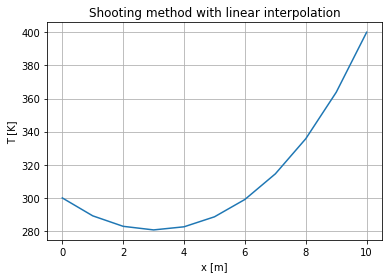

In [ ]:
# we first build the RHS function for both ODEs
# **** the independent and dependent variables (x, y) MUST be exactly in that order. ****
# **** Even if the independent variable is not used, it MUST be there                ****
dy = lambda x, y: np.array([y[1], -0.05 * (200 - y[0])])   # RHS function as an array

L = 10.
h = 1  #step size
xint = np.array([0., L])

z1 = -5. # z1=z(0)=dT/dx(0)=-5 is just an initial guess because we don't know its value beforehand
y0 = np.array([300., z1])  # initial conditions: T(x=0)=300, z1 is a guess
x, y = rk4sys(dy, xint, y0, h)      # using RK4 method
TL1 = y[0,-1]  # T(L) obtained using z=z1 guess.
print('Guess 1: z1 =z(0)=dT/dx(0)=-5 gives: T(L)=', TL1, ' > 400')  # y[0,-1]: 0 is for the first row of y which is T, 
                                                                    #         -1 is the index to the last element of the row which is T at x=L

z2 = -20. # z2=z(0)=dT/dx(0)=-20 is the 2nd initial guess
y0 = np.array([300., z2])      # initial conditions: T(x=0)=300, z2 is a guess                                            
x, y = rk4sys(dy, xint, y0, h)
TL2 = y[0,-1]
print('Guess 2: z2=z(0)=dT/dx(0)=-20 gives: T(L)=', TL2 , ' < 400')
print('Having one T(L)> 400 and one T(L) < 400, we know that the missing initial condition must be in between -5 and -20')
print('Using linear interpolation:')
z12 = np.array([z1, z2])
TL12 = np.array([TL1, TL2])
p = np.polyfit(TL12, z12, 1)  #linear interpolation: z as a function of T(L)
za = np.polyval(p, 400)       # the missing initial condition za for T(L) = 400
"""
za = lagrangeInt(TL12, z12, 400) # we could use Lagrange or Newton interpolation instead
"""
print('za = ', za, ' :the missing initial condition')
# Solve the ODE with the correct initial condition to get the correct solution  
y0 = np.array([300., za])                                                  
x, y = rk4sys(dy, xint, y0, h)
TL = y[0,-1]
print('za gives: T(L)=', TL , ' ~ 400 -> dT/dx(x = 0) = za is the correct initial condition -> y is the correct solution')
print()
plt.plot(x, y[0,:])
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.title('Shooting method with linear interpolation')
plt.show();


Note that both end points have the correct T values (T=300K at x=0 and T=400K at x=10) which indicates that that this is the correct solution to the boundary value problem.

## Shooting method via root finding

This method can handle both linear and nonlinear ODEs. Consider for example the same ODE ${d^2y \over dt^2} = f(t,y)$ subject to two conditions: $y=a$ at $t=0$ and $y=b$ at $t=1$. We start with $y=a$ at $t=0$ and we set the second initial condition (which is not given) as $y'=z$ at $t=0$. We find $z$ such that the solution to the ODE matches $y=b$ at $t=1$ at the other end. We know that the solution at the other end $y_{t_1}=y(1)$ is a function of $z$ and we see the $z$ value for which $y_{t_1}(z)=b$. We can therefore treat this as a root finding problem $f(z)=y_{t_1}(z)-b=0$ in which $z$ is the root of $f(z)=0$. $f(z)$ is called the **residual function**. 

### Example 2 - a linear ODE
Solve example 1 using root finding and compare the results with example 1.

This is a linear ODE and thus, we expect to get similar result as that in example 1.

We consider an initial value problem with initial conditions $T(x=0)=300$ and $z(x=0)=z_a$ where $z_a$ is unknown. We solve this initial value problem such that $T_L=T(x=L)=400$ is satisfied. This is done by solving  $f(z_a)=T_L(z_a)-400=0$ by root finding where $f(z_a)$ is the residual function. Note that the temperature at $x=L$ is a function of $z_a$. The solution to $f(z_a)=0$ is the missing initial condition $z_a$.

In python, we need to create a function to calculate the residual function. The input is z_a and the output is $f(z_a)$.

check modsecant: f= 0.0 ea= 8.287456025098306e-09 iter= 2
za =  -13.207184047496751 : the missing initial condition

za gives: T(L)= 400.0  ~ 400 -> dT/dx(x=0)=za is the correct initial condition -> y is the correct solution



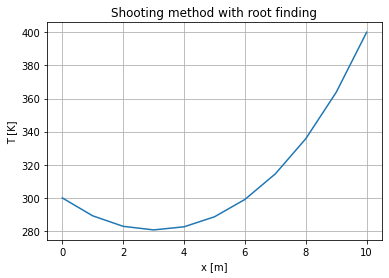

In [ ]:
dy = lambda x, y: np.array([y[1], -0.05 * (200 - y[0])])   # RHS function as an array
L = 10.
T0 = 300.
h = 1.
xint = np.array([0., L])

# *** We need to create a function to calcualte the residual function ***
def residual(za): # construct the residual function
  """
  Calculates the residual function as the function of z
  """
  y0 = np.array([T0, za])         # T(x=0)=300, set the initial condition with new z values
  x, y = rk4sys(dy, xint, y0, h) # using RK4 method to get the T(x) distribution with the new initial condition
  res = y[0,-1] - 400            # This is the f(za)=TL(za)-400 for this problem
  return res


z0 = -10 # initial guess for z
za, fx, ea, iter = modsecant(residual, z0, delta=1e-6,  tol=1e-6)  #root finding using modified secant, it returns za, the missing initial condition
print ('check modsecant: f=', fx, 'ea=', ea, 'iter=', iter)
"""
# We could also use other root finding method. Here is the implementation using 
# fsolve but note that we need to use z[0] inside the residual function. This is how fsolve passes arguments otherwise it gives errors
def residual(za):
  y0 = np.array([T0, za[0]])
  x, y = rk4sys(dy, xint, y0, h)
  res = y[0,-1] - 400
  return res


from scipy.optimize import fsolve
xf = fsolve(residual, z0, xtol = tol)
za = xf[0]
"""
print('za = ', za, ': the missing initial condition')
# Solve the ODE with the correct initial condition to get the correct solution   
y0 = np.array([T0, za])                                                  
x, y = rk4sys(dy, xint, y0, h)
TL = y[0,-1]  #T at the end point
print()
print('za gives: T(L)=', TL , ' ~ 400 -> dT/dx(x=0)=za is the correct initial condition -> y is the correct solution')
print()
plt.plot(x, y[0,:])
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.title('Shooting method with root finding')
plt.show();



$z_a$ is similar to that in example 1 and therefore, the $T(x)$ is almost idential to that in example 1 as well.

### Example 3 - a nonlinear ODE with Dirichlet boundary condition

Consider this nonlinear ODE $\frac{d^2T}{dx^2} + 0.05(200 -T)+2.7\times 10^{-9}(200^4-T^4)=0$ subject to $T(x=0)=300\,K$ and $T(x=L)=400\,K$, where $L=10\,m$. This equation describes the steady-state temperature distribution in a rod due to heat conduction and radiation.

We use the shooting method with root finding since this is a nonlinear ODE. The boundary conditions given are Dirichlet boundary conditions.

We first convert this 2nd order ODE into a systems of 2 first order ODEs:
$$\begin{cases} 
\frac{dT}{dx}=z\\
\frac{dz}{dx}=- 0.05(200 -T)-2.7\times 10^{-9}(200^4-T^4) \\ 
\end{cases}$$



check modsecant: f= -1.2505552149377763e-12 ea= 2.734095184307971e-09 iter= 14
za =  -41.7599547298563

za gives: T(L)= 399.99999999999875  ~ 400 -> dT/dx(0)=za is the correct initial condition -> y is the correct solution


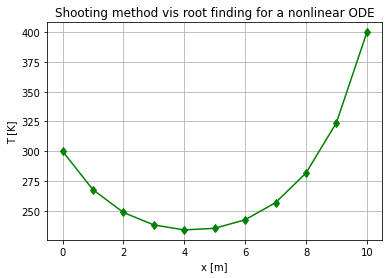

In [ ]:
# Example 3
dy = lambda x, y: np.array([y[1], -0.05 * (200 - y[0]) -2.7e-9 * (200**4 - y[0]**4)])   # RHS function as an array
L = 10.
T0 = 300.
h = 1.  # step size
xint = np.array([0., L])

def residual(z): # residual function
  y0 = np.array([T0, z])              # T(x=0)=300
  x, y = rk4sys(dy, xint, y0, h)      # using RK4 method  
  res = y[0,-1] - 400
  return res


z0 = -50 # initial guess for z
za, fx, ea, iter = modsecant(residual, z0, delta=1e-6,  tol=1e-6) #root finding using modified secant method
print ('check modsecant: f=', fx, 'ea=', ea, 'iter=', iter)
print('za = ', za) #the missing initial condition (the solution to f(z)=0)
y0 = np.array([300., za])                                                  
x, y = rk4sys(dy, xint, y0, h)
TL = y[0,-1]  #T at the end point
print()
print('za gives: T(L)=', TL , ' ~ 400 -> dT/dx(0)=za is the correct initial condition -> y is the correct solution')
plt.plot(x, y[0,:],'gd-')
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.title('Shooting method via root finding for a nonlinear ODE')
plt.show();



### Example 4 - a nonlinear ODE with Neumann boundary condition

Consider this nonlinear ODE $\frac{d^2T}{dx^2} + 0.05(200 -T)+2.7\times 10^{-9}(200^4-T^4)=0$ subject to $T(x=L)=400\,K$, where $L=10\,m$. At $x=0$, we have $\frac{dT}{dx}=0$ which is the insulated wall condition.  This equation describes the steady-state temperature distribution in a rod due to heat conduction and radiation with insulated wall at $x=0$.

The boundary condition at $x=0$ is a Neumann boundary condition. We solve this ODE using shooting method since it is nonlinear ODE.

We first convert this 2nd order ODE into a systems of 2 first order ODEs:
$$\begin{cases} 
\frac{dT}{dx}=z\\
\frac{dz}{dx}=- 0.05(200 -T)-2.7\times 10^{-9}(200^4-T^4) \\ 
\end{cases}$$

Both $T(0)=T_a$ is the unknown boundary condition while $\frac{dT}{dx}(0)=0 $ is given. The temperature distribution in the rod is a function of $T_a$ and our objective is to find $T_a$ such that $T$ at $x=L$ (*i.e.,* $T_L=T(x=L)$) equal to $400\,K$. We thus define the residual function as $f(T_a)=T_L(T_a)-400$. The missing boundary condition $T_a$ is a root of $f(T_a)=0$.

check modsecant: f= 6.252776074688882e-13 ea= 1.6065510863185766e-10 iter= 6
Ta =  207.23393554242236
Ta gives: T(L)= 400.0000000000006  ~ 400 -> Ta is the correct initial condition -> y is the correct solution



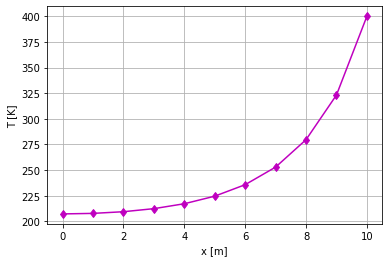

In [ ]:
# Example 4
dy = lambda x, y: np.array([y[1], -0.05 * (200 - y[0]) -2.7e-9 * (1.6e9 - y[0]**4)])   # RHS function as an array
L = 10.
h = 1.
xint = np.array([0., L])
z0 = 0.  #initial condition z(0)=dT/dx(0)=0

def residual(Ta): #Ta is the unknown
  y0 = np.array([Ta, z0])  # initial conditions
  x, y = rk4sys(dy, xint, y0, h)      # using RK4 method  
  res = y[0,-1] - 400  #f(Ta) = TL(Ta) - 400
  return res


T0 = 200 # initial guess for T(0)
Ta, fx, ea, iter = modsecant(residual, T0, delta=1e-6,  tol=1e-6)
print ('check modsecant: f=', fx, 'ea=', ea, 'iter=', iter)
print('Ta = ', Ta)  #the missing initial condition (solution to f(T0)=0)
y0 = np.array([Ta, z0])                                                  
x, y = rk4sys(dy, xint, y0, h)
TL = y[0,-1]
print('Ta gives: T(L)=', TL , ' ~ 400 -> Ta is the correct initial condition -> y is the correct solution')
print()
plt.plot(x, y[0,:],'md-')
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.show();



### Example 5 - a nonlinear ODE with Mixed boundary condition

Consider this nonlinear ODE $\frac{d^2T}{dx^2} + 0.05(200 -T)+2.7\times 10^{-9}(200^4-T^4)=0$ subject to $T(x=L)=400\,K$, where $L=10\,m$. At $x=0$, we have $\frac{dT}{dx}(0)=-0.05(T(0)-200)$ which is the convective heat transfer boundary condition.  This equation describes the steady-state temperature distribution in a rod due to heat conduction and radiation with convection at $x=0$.

The boundary condition at $x=0$ is a mixed boundary condition. We solve this ODE using shooting method since it is nonlinear ODE.

We first convert this 2nd order ODE into a systems of 2 first order ODEs:
$$\begin{cases} 
\frac{dT}{dx}=z\\
\frac{dz}{dx}=- 0.05(200 -T)-2.7\times 10^{-9}(200^4-T^4) \\ 
\end{cases}$$
Both $T(0)$ and $\frac{dT}{dx}(0)$ are unknown at $x=0$, that is both initial conditions are missing! However, we can find a relationship between them using the mixed boundary condition given:
$z(0) = \frac{dT}{dx}(0)=0.05(T(0)-200)$. Thereofore, by assigning value to $T(0)=T_a$ we can also calculate $z(0)$ and thus, we are dealing with just one unknown ($T_a$). The goal is find $T_a$ to make $T$ at $x=L$ (*i.e.,* $T_L=T(x=L)$) equal to $400\,K$. The residual function is thus defined as $f(T_a)=T_L(T_a)-400$, and $T_a$ is a root of $f(T_a)=0$.


check modsecant: f= 3.979039320256561e-13 ea= 1.1968846015518574e-10 iter= 6
Ta =  206.40377363762755

Ta gives: T(L)= 400.0000000000004  ~ 400 -> Ta is the correct initial condition -> y is the correct solution



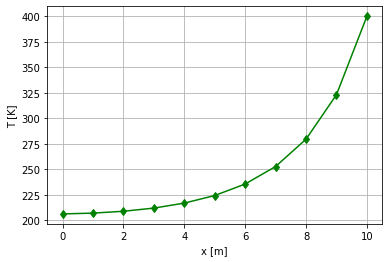

In [ ]:
# Example 5
dy = lambda x, y: np.array([y[1], -0.05 * (200 - y[0]) -2.7e-9 * (1.6e9 - y[0]**4)])   # RHS function as an array
L = 10.
h = 1.
xint = np.array([0., L])

def residual(Ta): #Ta is the unknown
  z0 = 0.05 * (Ta - 200.) # we calculate z(0)=dT/dx(0) from T0 using the mixed boundary condition
  y0 = np.array([Ta, z0])  # initial conditions
  x, y = rk4sys(dy, xint, y0, h)      # using RK4 method  
  res = y[0,-1] - 400  #f(Ta) = TL(Ta) - 400
  return res


T0 = 200 # initial guess for T(0)
Ta, fx, ea, iter = modsecant(residual, T0, delta=1e-6,  tol=1e-6)
print ('check modsecant: f=', fx, 'ea=', ea, 'iter=', iter)
print('Ta = ', Ta)  #the missing initial condition (solution to f(T0)=0)
za = 0.05 * (Ta - 200.)
y0 = np.array([Ta, za])                                                  
x, y = rk4sys(dy, xint, y0, h)
TL = y[0,-1]
print()
print('Ta gives: T(L)=', TL , ' ~ 400 -> Ta is the correct initial condition -> y is the correct solution')
print()
plt.plot(x, y[0,:],'gd-')
plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.show();



# Exercise

Use the shooting method to solve $7{d^2y \over dx^2} - 2{dy \over dx}-y+x=0$ with boundary conditions $y(0)=5$ and $y(20)=8$. Use both shooting method with interpolation and root finding and compare the results.